# [프로젝트] 멀티 에이전트 기반 Research Agent 만들기

STORM, Open Deep Research의 구조에 착안하여,   
적절한 로직을 세우고 작동하는 Research Agent를 만들어 보겠습니다.

In [7]:
!pip install langgraph dotenv arxiv langchain-tavily langchain-community langchain-google-genai pymupdf

In [8]:
from dotenv import load_dotenv
import os

# GOOGLE_API_KEY, TAVILY_API_KEY 필수
load_dotenv()

True

LangSmith 설정

In [9]:
os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'

## Preliminary

이번 실습에서는, 그동안 사용하지 않았던 랭체인의 특별한 기능들을 더 활용해 보겠습니다.

#### 다중 LLM 사용하기

LangChain의 `init_chat_model`은 provider와 model 정보를 입력하는 방식으로   
다양한 모델을 불러올 수 있는 기능입니다.

In [10]:
import os
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain.chat_models import init_chat_model
from rich import print as rprint

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

quick_rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.333,  # 분당 20개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=20,  # 최대 버스트 크기
)



llm = init_chat_model(
    model_provider="google_genai",
    model="gemini-2.0-flash",
    # model = "gemini-2.0-flash-lite"
    # model = "gemini-2.0-flash-thinking-exp"
    rate_limiter=rate_limiter,
    temperature=0.8,
)

rprint(llm)

ChatGoogleGenerativeAI(
    rate_limiter=<langchain_core.rate_limiters.InMemoryRateLimiter object at 0x7ee0bbeceed0>,
    model='models/gemini-2.0-flash',
    google_api_key=SecretStr('**********'),
    temperature=0.8,
    client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object 
at 0x7edfd349eff0>,
    default_metadata=(),
    model_kwargs={}
)

## Configurables   

LangGraph 어플리케이션의 작동을 조율하기 위해, State와 함께 `Configurable`를 추가할 수 있습니다.


In [11]:
from langchain_core.runnables.config import RunnableConfig
from typing_extensions  import TypedDict, Optional

class Configuration(TypedDict):

    # Search Metadata
    num_search_queries: int
    max_search_depth: int

    # Models
    planner_model:str
    planner_provider:str

    writer_model:str
    writer_provider:str

    evaluator_model: str
    evaluator_provider: str

    quick_model: str
    quick_provider: str

    search_api: list[str]

# Default
default = Configuration(
    num_search_queries=3, # 섹션별 질문 쿼리 수
    max_search_depth=2,# 파생 질문이 생길 경우, 몇 단계까지 수행할지

    planner_model='models/gemini-2.0-flash',
    planner_provider='google-genai',

    writer_model='models/gemini-2.0-flash',
    writer_provider='google-genai',

    evaluator_model='models/gemini-2.0-flash',
    evaluator_provider='google-genai',

    quick_model='models/gemini-2.0-flash-lite',
    quick_provider='google-genai',

    search_api=['tavily'] # 이후 다른 검색 엔진 추가
)



#### 검색 API 활용하기   
이번 프로젝트에서는 2개의 검색 API를 활용합니다.

1. Tavily Search
3. Arxiv Search

추가적인 검색 엔진으로는
PubMed 등의 도메인 특화 검색이나, Perplexity, Exa 등의 유료 API를 연결할 수 있습니다.

Tavily Search를 구성합니다.   
만약 모듈의 Argument를 LLM이 판단하게 하고 싶다면,   
해당 함수를 툴로 감싸는 식으로 만들면 됩니다.

In [12]:
# Tavily Search

from langchain_tavily import TavilySearch

# tavily api playground 참고
tavily_search = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    include_raw_content=True,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [13]:
result = tavily_search.invoke("Retrieval Augmented Generation Reasoning")
len(result)

7

In [14]:
for i in result['results']:
    print(i['title'])

Open-RAG: Enhanced Retrieval-Augmented Reasoning with ... - arXiv
Open-RAG: Enhanced Retrieval Augmented Reasoning with Open ...
ReAG: Reasoning-Augmented Generation - Superagent
Retrieval-Augmented Reasoning with Trustworthy Process Rewarding
Search-o1 Agentic Retrieval Augmented Generation with reasoning


논문과 테크 리포트를 검색하는 학술 검색 API입니다.

In [15]:
from langchain_community.retrievers import ArxivRetriever

arxiv_search = ArxivRetriever(
    load_max_docs=5,
    load_all_available_meta=True,
    get_full_documents=True,
    doc_content_chars_max= 100000
    # 10만 글자까지만 수집

)

In [16]:
docs = arxiv_search.invoke("Retrieval Augmented Generation Reasoning")
# docs

In [17]:
for doc in docs:
    print(f"Published: {doc.metadata['Published']}")
    print(f"Title: {doc.metadata['Title']}")
    print(f"Authors: {doc.metadata['Authors']}")
    print(f"Summary: {doc.metadata['Summary']}")
    print(f"Length: {len(doc.page_content)}")
    print("-" * 50)



Published: 2025-06-19
Title: Enhancing Document-Level Question Answering via Multi-Hop Retrieval-Augmented Generation with LLaMA 3
Authors: Xinyue Huang, Ziqi Lin, Fang Sun, Wenchao Zhang, Kejian Tong, Yunbo Liu
Summary: This paper presents a novel Retrieval-Augmented Generation (RAG) framework
tailored for complex question answering tasks, addressing challenges in
multi-hop reasoning and contextual understanding across lengthy documents.
Built upon LLaMA 3, the framework integrates a dense retrieval module with
advanced context fusion and multi-hop reasoning mechanisms, enabling more
accurate and coherent response generation. A joint optimization strategy
combining retrieval likelihood and generation cross-entropy improves the
model's robustness and adaptability. Experimental results show that the
proposed system outperforms existing retrieval-augmented and generative
baselines, confirming its effectiveness in delivering precise, contextually
grounded answers.
Length: 16815
----------

각각의 검색 API를 아래와 같이 정리해 놓겠습니다.

In [18]:
tool_list = {
    'tavily': tavily_search,
    'arxiv': arxiv_search,
}

전체 과정은 다음과 같이 이루어집니다.

1) 연구 토픽을 입력하면, LLM이 추가 정보를 질문합니다.    
유저는 그대로 진행하거나, 피드백을 전달합니다.

2) 연구 토픽에 대해, LLM이 간단한 검색을 수행하고 이를 바탕으로 연구 개요를 작성합니다.   

3) 개요에 포함된 각 세션에 대해, LLM이 검색 쿼리를 생성하여 각 검색엔진을 통해 검색합니다.   

4) 검색된 결과를 바탕으로 섹션별 내용을 작성합니다.    
(검색 결과에 대한 레퍼런스 표시를 포함합니다.)

5) 섹션별 드래프트를 개선하기 위해, 파생 질문을 추가로 생성하여 더 검색하거나 작성을 종료합니다.


6) 섹션별 내용을 취합하고, 최종 수정을 거친 뒤 리포트를 완성합니다.



In [21]:
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langgraph.types import Command, interrupt
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel, Field
from typing_extensions import Annotated, Literal
import operator
from langgraph.types import Send

## 작업에 사용할 클래스 만들기   
Structured Output을 위한 클래스를 먼저 구성합니다.

In [22]:
class Section(BaseModel):
    name: str = Field(description="섹션의 이름")
    description: str = Field(description="해당 섹션에서 다룰 주요 주제에 대한 간략한 개요")
    content: str = Field(description="섹션의 내용 (처음에는 비워 둡니다)")

    @property
    def as_str(self) -> str:
        """섹션의 정보를 포맷팅된 문자열로 변환합니다."""
        return f"### {self.name}\n{self.description}\n\n내용:\n{self.content}"

class ReportPlan(BaseModel):
    sections: list[Section] = Field(description="A list of sections for the report.")
    followup_question: str = Field(description="사용자에게 추가로 질문할 내용 (없으면 '')")

    @property
    def as_str(self) -> str:
        """섹션들을 포맷팅된 문자열로 변환합니다."""
        sections_str = []
        for section in self.sections:
            sections_str.append(f"### {section.name}\n{section.description}")
        return "\n\n".join(sections_str)

## 서브모듈: 토픽에 대한 리서치 모듈 만들기

섹션의 개요가 주어지면, 해당 내용을 검색하여 섹션을 작성하는 과정을 구현해 보겠습니다.

In [23]:
class ResearchState(TypedDict):
    topic: str
    section: Section
    queries: list[str]
    draft: str
    resources: list
    num_revision: int
    finished: bool


def generate_search_query(state: ResearchState, config: RunnableConfig):
    prompt = ChatPromptTemplate([
('system', f'''
주어진 섹션 정보에 대한 사전 조사를 위해, 효과적인 검색 쿼리를 생성해야 합니다.
해당 주제를 포괄적으로 다룰 수 있는 검색 쿼리들을 생성하세요.

검색 쿼리는 다음과 같은 원칙을 따라야 합니다:
1. 핵심 키워드를 포함해야 합니다
2. 너무 일반적이지 않아야 합니다
3. 학술적이고 전문적인 용어를 사용해야 합니다
4. 최신 연구 동향을 반영해야 합니다
5. 따옴표를 포함하지 않아야 합니다.

적절한 검색 쿼리를 한 줄에 하나씩 작성하세요.
쿼리만 출력하고, {config['configurable']['num_search_queries']} 개의 쿼리를 출력하세요.

'''),
('user', '''
섹션 정보:
{section}

''')])
    section = state['section']

    writer_llm = init_chat_model(
        model_provider = config['configurable']['writer_provider'],
        model= config['configurable']['writer_model'],
        rate_limiter=rate_limiter,
        temperature=0.8,
        max_tokens = 8192
    )


    chain = prompt | writer_llm | StrOutputParser() | (lambda x: x.split('\n'))

    queries = chain.invoke(section.as_str)

    return {'queries':queries}

def search_and_filter(state: ResearchState, config: RunnableConfig):
    '''각각의 검색어에 대해 검색 결과를 수행하고 필터링합니다.
    Tavily Search는 정확성이 높기 때문에, 해당 부분을 생략해도 됩니다..
    빠른 LLM을 사용하겠습니다.
    '''
    quick_llm = init_chat_model(
        model_provider = config['configurable']['quick_provider'],
        model= config['configurable']['quick_model'],
        rate_limiter=quick_rate_limiter,
        temperature=0.8,
    )

    search_tool = tool_list[config['configurable']['search_api'][0]]
    # 적절한 검색 툴 선택 (여기서는 Tavily로 고정)

    queries = state['queries']
    section = state['section']

    relevant_docs=[]


    filter_prompt=ChatPromptTemplate([
        ('system', f'''다음 검색 결과가 주어진 주제와 관련이 있는지 O/X로 판단하세요.
O/X만 출력하세요.
---
주제: {section.as_str}'''),

('user', '''
검색 결과: {doc}''')])
    chain = filter_prompt | quick_llm | StrOutputParser()

    context = search_tool.batch(queries)
    # 모든 검색 쿼리를 한번에 실행

    def preprocess(text):
        import re
        # 탭과 개행문자를 공백으로 변환
        text = text.replace('\t', ' ').replace('\n', ' ').replace('\xa0', ' ')
        # 템플릿 오류 방지
        text = text.replace('{', '(').replace('}', ')')

        # 연속된 공백을 하나로 치환
        text = re.sub(r'\s+', ' ', text).strip()
        return text


    for docs in context:
        try:
            for doc in docs['results']:
                doc_str = f"### {doc['title']} \n URL: {doc['url']} \n {doc['raw_content']}" if doc.get('raw_content') else f"### {doc['title']} \n {doc['content']}"
                # 하나로 만든 뒤 전처리
                doc_str = preprocess(doc_str)
                relevance = chain.invoke(doc_str)
                if relevance=='O':
                    relevant_docs.append(doc_str)
        except: # 검색 오류시
            continue
    print(f'# Filtered Docs: {len(relevant_docs)}')
    return {'resources':relevant_docs}

def write_section(state: ResearchState, config: RunnableConfig):
    section = state['section'].as_str
    topic = state['topic']
    resources = state['resources']
    draft = state.get('draft', '')

    writer_prompt =ChatPromptTemplate([
        ('system', '''
연구 리포트의 주제와 세부 섹션명이 주어집니다.
아래의 정보를 활용하여, 연구 리포트의 한 섹션을 작성하세요.
다음은 작성 가이드라인입니다.

[작성 가이드라인]
간단하고 명확한 언어를 사용하세요.
섹션명은 마크다운 ## 으로 작성하며, 세부 목차는 만들지 말고 문단으로만 분리하세요.
문장을 너무 길게 쓰지 말고, 이해하기 쉽게 작성하세요.
'이다.' 가 아닌 '입니다.', '합니다.' 등의 스타일로 작성하세요.
또한, 아래에 주어지는 정보의 내용을 최대한 활용하여 작성하세요.


[인용 가이드라인]
인용 표시는 [1], [2]와 같이 작성하고, 섹션 마지막에 레퍼런스를 작성하세요.
레퍼런스 형식은 MLA 표기를 따르고, 마지막에 URL도 표시하세요.
예시 표시 형식은 다음과 같습니다.

**References**
[1] Unite.AI. "DeepMind의 Michelangelo 벤치마크: Long-Context LLM의 한계를 드러내다." *Unite.AI*, [https://www.unite.ai/ko/
<br><br>
[2] ...


[노트]
인용 표시를 정확하게 했는지 확인하고, 주장이 기술되는 경우 가급적 소스에 근거하도록 작성하세요.
마크다운 형식을 고려하여, 문단 분리나 레퍼런스 사이의 줄바꿈을 명확하게 하세요.

[기존 드래프트]

기존 드래프트가 주어지는 경우, 여기에 이어서 작성하세요.
'''),

('user',f'''
주제: {topic}

세부 섹션명: {section}

검색 결과 Context:
{resources}

기존 Draft:
{draft}
''')
])
    writer_llm = init_chat_model(
        model_provider = config['configurable']['writer_provider'],
        model= config['configurable']['writer_model'],
        rate_limiter=rate_limiter,
        temperature=0.8,
        max_tokens = 8192
    )
    chain = writer_prompt | writer_llm | StrOutputParser()
    draft = chain.invoke({})
    return {'draft':draft}

class Feedback(BaseModel):
    grade : Literal['Good', 'Bad'] = Field(description='드래프트에 대한 평가')
    queries: Optional[list[str]] = Field(description='검색 쿼리 목록')

def refine_research(state: ResearchState, config: RunnableConfig) -> Command[Literal[END, "search_and_filter"]] :
    '''Draft와 context를 평가하여, 추가 검색이 필요한지 판단합니다.
    Revision 개수를 초과하면 바로 END로 이동합니다.'''

    section = state['section'].as_str
    topic = state['topic']
    resources = state['resources']
    draft = state['draft']
    queries = state['queries']
    num_revision = state['num_revision']

    prompt = ChatPromptTemplate([
        ('system', f'''
연구 리포트의 주제와 세부 섹션명이 주어집니다.

현재 작성된 섹션의 드래프트를 평가하세요.

이 글의 내용을 명확하고 유익하게 작성하기 위해,
검색된 결과 이외의 새로운 내용을 더 조사해야 하는지 판단하세요.

이후, 추가 검색을 위해 필요한 검색어 쿼리를 작성하세요.
{config['configurable']['num_search_queries']} 개 이하의 쿼리를 출력하세요.

해당 글은 충분히 완성도가 높아 추가 조사가 필요하지 않을 수도 있습니다.
그런 경우에는 'Good'을 출력하고, 추가 쿼리를 비워두세요.
'''),

('user',f'''
주제: {topic}

세부 섹션명: {section}


드래프트: {draft}''')
])
    # revision 개수 넘어가면 바로 END
    if num_revision >= config['configurable']['max_search_depth']:
         return Command(goto = END,
                       update = {'finished':True})


    evaluator_llm = init_chat_model(
        model_provider = config['configurable']['evaluator_provider'],
        model= config['configurable']['evaluator_model'],
        rate_limiter=rate_limiter,
        temperature=0.8,
    )


    chain = prompt | evaluator_llm.with_structured_output(Feedback)

    feedback = chain.invoke({})

    if feedback.grade =='Good':
        return Command(goto = END,
                       update = {'finished':True})
    else:
        return Command(goto = 'search_and_filter',
                       update= {'queries': feedback.queries,
                                'num_revision': num_revision+1})

Research Agent를 구성하는 Small Graph를 만듭니다.

In [24]:
builder = StateGraph(ResearchState)
builder.add_node(generate_search_query)
builder.add_node(search_and_filter)
builder.add_node(write_section)
builder.add_node(refine_research)


builder.add_edge(START, 'generate_search_query')
builder.add_edge('generate_search_query', 'search_and_filter')
builder.add_edge('search_and_filter', 'write_section')
builder.add_edge('write_section', 'refine_research')

memory = MemorySaver()



researcher_graph = builder.compile(checkpointer=memory)

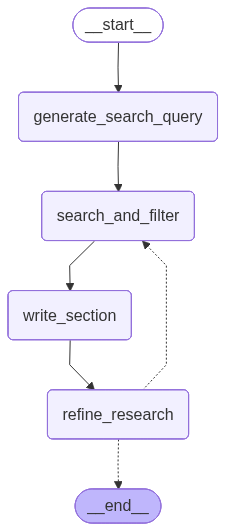

In [25]:
researcher_graph

In [26]:
t = Section(name='Case Study: LLama 4의 Long Context',
            description='Llama 4 모델의 10M Context의 비결에 대해 설명합니다.',
            content='')

In [27]:
test_research_state={
    'topic': '1M Context Windows 모델',
    'section': t,
    'num_revision':0
}

# Thread
thread = {'configurable':default, 'thread_id':'1'}

history = []
for event in researcher_graph.stream(test_research_state, thread, stream_mode="updates"):
    for status in event:
        print(f'# {status}')
        for key in event[status]:
            value = str(event[status][key])
            if len(value)>300:
                print(f'- {key}: {value[:300]}')
            else:
                print(f'- {key}: {value}')
        print('---------')
    history.append(event)

# generate_search_query
- queries: ['Llama 4 10M context length architecture', 'Llama 4 long context training techniques', 'Llama 4 scaling context length transformer models']
---------
# Filtered Docs: 15
# search_and_filter
- resources: ["### Llama 4's Architecture Deconstructed: MoE, iRoPE, and Early ... URL: https://medium.com/@mandeep0405/llama-4s-architecture-deconstructed-moe-irope-and-early-fusion-explained-e58eb9403067 Published Time: 2025-05-04T02:00:05Z Llama 4’s Architecture Deconstructed: MoE, iRoPE, and Early Fusion Exp
---------
# write_section
- draft: ### Case Study: LLama 4의 Long Context

Llama 4 모델은 최대 10M 토큰에 달하는 긴 문맥을 처리할 수 있는 능력을 갖추고 있습니다 [1]. 이러한 긴 문맥 처리를 가능하게 하는 핵심 기술은 iRoPE(interleaved Rotary Position Embeddings)입니다 [2]. iRoPE는 RoPE 레이어와 NoPE 레이어를 번갈아 배치하여, 로컬 패턴과 글로벌 문맥을 효과적으로 이해하도록 설계되었습니다 [3].

RoPE 레이어는 토큰의 상대적인 위치 정보를 활용하여 문맥을 파악하는 데
---------
# refine_research
- finished: True
---------


작성한 섹션 드래프트를 확인해 보겠습니다.

In [28]:
history[-2]

{'write_section': {'draft': '### Case Study: LLama 4의 Long Context\n\nLlama 4 모델은 최대 10M 토큰에 달하는 긴 문맥을 처리할 수 있는 능력을 갖추고 있습니다 [1]. 이러한 긴 문맥 처리를 가능하게 하는 핵심 기술은 iRoPE(interleaved Rotary Position Embeddings)입니다 [2]. iRoPE는 RoPE 레이어와 NoPE 레이어를 번갈아 배치하여, 로컬 패턴과 글로벌 문맥을 효과적으로 이해하도록 설계되었습니다 [3].\n\nRoPE 레이어는 토큰의 상대적인 위치 정보를 활용하여 문맥을 파악하는 데 효과적입니다 [3]. 반면, NoPE 레이어는 위치 정보를 사용하지 않고 모든 토큰에 동일한 주의를 기울여 전체적인 문맥을 파악하는 데 도움을 줍니다 [3]. 이러한 두 종류의 레이어를 번갈아 사용함으로써, Llama 4는 세밀한 로컬 문맥과 광범위한 글로벌 문맥을 동시에 이해할 수 있습니다 [3].\n\niRoPE 외에도, Llama 4는 추론 시 온도 스케일링(temperature scaling)을 적용하여 긴 시퀀스에 대한 일반화 성능을 향상시킵니다 [3]. 이 기술은 attention score를 조정하여 모델이 문맥 내에서 중요한 토큰에 집중할 수 있도록 돕습니다 [3]. 이러한 기술들의 조합을 통해 Llama 4는 이전 모델에 비해 훨씬 긴 문맥을 효과적으로 처리할 수 있게 되었습니다 [1].\n\n**References**\n\n[1] Unite.AI. "DeepMind의 Michelangelo 벤치마크: Long-Context LLM의 한계를 드러내다." *Unite.AI*, [https://www.unite.ai/ko/deepminds-michelangelo-benchmark-reveals-limitations-of-long-context-llms/](https://www.unite.ai/ko/deepminds-michelangelo-benchmark-rev

In [29]:
from IPython.display import display
from IPython.display import Markdown
import textwrap

result = history[-2]['write_section']['draft']

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

to_markdown(result)


> ### Case Study: LLama 4의 Long Context
> 
> Llama 4 모델은 최대 10M 토큰에 달하는 긴 문맥을 처리할 수 있는 능력을 갖추고 있습니다 [1]. 이러한 긴 문맥 처리를 가능하게 하는 핵심 기술은 iRoPE(interleaved Rotary Position Embeddings)입니다 [2]. iRoPE는 RoPE 레이어와 NoPE 레이어를 번갈아 배치하여, 로컬 패턴과 글로벌 문맥을 효과적으로 이해하도록 설계되었습니다 [3].
> 
> RoPE 레이어는 토큰의 상대적인 위치 정보를 활용하여 문맥을 파악하는 데 효과적입니다 [3]. 반면, NoPE 레이어는 위치 정보를 사용하지 않고 모든 토큰에 동일한 주의를 기울여 전체적인 문맥을 파악하는 데 도움을 줍니다 [3]. 이러한 두 종류의 레이어를 번갈아 사용함으로써, Llama 4는 세밀한 로컬 문맥과 광범위한 글로벌 문맥을 동시에 이해할 수 있습니다 [3].
> 
> iRoPE 외에도, Llama 4는 추론 시 온도 스케일링(temperature scaling)을 적용하여 긴 시퀀스에 대한 일반화 성능을 향상시킵니다 [3]. 이 기술은 attention score를 조정하여 모델이 문맥 내에서 중요한 토큰에 집중할 수 있도록 돕습니다 [3]. 이러한 기술들의 조합을 통해 Llama 4는 이전 모델에 비해 훨씬 긴 문맥을 효과적으로 처리할 수 있게 되었습니다 [1].
> 
> **References**
> 
> [1] Unite.AI. "DeepMind의 Michelangelo 벤치마크: Long-Context LLM의 한계를 드러내다." *Unite.AI*, [https://www.unite.ai/ko/deepminds-michelangelo-benchmark-reveals-limitations-of-long-context-llms/](https://www.unite.ai/ko/deepminds-michelangelo-benchmark-reveals-limitations-of-long-context-llms/)
> 
> [2] Singh, Mandeep. "Llama 4’s Architecture Deconstructed: MoE, iRoPE, and Early Fusion Explained." *Medium*, 4 May 2025, [https://medium.com/@mandeep0405/llama-4s-architecture-deconstructed-moe-irope-and-early-fusion-explained-e58eb9403067](https://medium.com/@mandeep0405/llama-4s-architecture-deconstructed-moe-irope-and-early-fusion-explained-e58eb9403067)
> 
> [3] Better Stack. "Llama 4 Has a 10M Token Context Window... (and its the best)." *Youtube*, 5 Apr. 2025, [https://www.youtube.com/watch?v=xCxuNE2wMPA](https://www.youtube.com/watch?v=xCxuNE2wMPA)

섹션별 Writer를 구성했습니다.   
이제 해당 그래프를 서브모듈로 하는 에이전트 구조를 구성합니다.

In [30]:
class State(TypedDict):
    topic: str # 리포트 주제
    plan: ReportPlan # 리포트 개요
    result: str # 최종 결과물 (하나로 합쳐진)
    human_feedback:str # 개요에 대한 인간 피드백
    finished_drafts: Annotated[list[str], operator.add]
    # (아마도) 병렬 처리로 생성될 draft들을 순서대로 합침


요청을 받은 뒤, 초기 설정과 함께 부가 질문을 수행합니다.

In [31]:
def initiate_report(state: State , config: RunnableConfig):

    prompt = ChatPromptTemplate([
        ('system','''
당신은 주어진 주제에 대한 연구 보고서의 초기 방향 설정을 위한 개요를 구성합니다.
최대한 최신의 지식과 인사이트를 활용하여야 하며, 사용자를 위한 맞춤형 보고서가 되어야 합니다.

주어진 주제에 대한 섹션별 개요를 작성하세요.
단, 마지막 섹션인 결론은 제외하고 작성하세요.

각 섹션은 불필요한 요소를 포함하지 말아야 하며, 명확하게 구분되어야 합니다.
섹션 간의 겹치는 내용을 최대한 줄이고, 각각의 역할이 분명하도록 구성하세요.

또한, 최종 결과 보고서에 사용자의 선호를 최대한 반영하기 위해,
사용자에게 추가로 질문할 내용도 작성하세요.
예를 들어, 세부 분야, 적용하고자 하는 환경, 원하는 정리 형식 등을 질문할 수 있습니다.

다음은 예시입니다.

---
질문: LLM 파인 튜닝 방법인 LoRA의 최근 발전된 모델들에 대해 조사해줘


답변:
개요: (보고서의 개요)
추가 질문: LoRA 기반 LLM 파인튜닝 관련 최근 발전된 모델들에 대해 조사해드릴게요.
아래 항목들 중 가능한 정보를 알려주시면 더 정확한 조사를 도와드릴 수 있어요:
용도 (예: 챗봇, 코드 생성, 번역, 의료 등)
적용 환경 (예: 연구용, 기업 서비스용, 모바일 디바이스 등)
원하시는 정리 형식 (예: 표, 요약 보고서, 논문 중심 정리 등)
가능한 범위를 알려주시면 곧바로 조사 시작할게요!'''),

('human', '''사용자의 주제(혹은 요청): {topic}

---

관련 최신 검색 결과:
{context}
 ''')
    ])

    topic = state['topic']

    search_tool =  tool_list[config['configurable']['search_api'][0]]
    # 적절한 검색 툴 선택 (여기서는 Tavily로 고정)


    context = search_tool.invoke(topic)
    # 초기 검색을 수행하여 개요 작성

    planner_llm = init_chat_model(
        model_provider = config['configurable']['planner_provider'],
        model= config['configurable']['planner_model'],
        rate_limiter=rate_limiter,
        temperature=0.8,
    ).with_structured_output(ReportPlan)

    chain = prompt | planner_llm

    result = chain.invoke({'topic': topic, 'context' : context})

    print('# Planner: ')

    print(f'''
# 보고서 작성 개요:
{result.as_str}

# 추가 질문:
{result.followup_question}''')
    return {'plan':result}


In [32]:
def human_review(state: State , config: RunnableConfig):

    human_review = interrupt(
        {
            "question": "피드백을 전달해 주세요, 이대로 진행하고 싶으시면, continue 또는 go만 입력하세요.",
        }
    )
    # Human Feedback을 받아 전달
    review_action = human_review.get("human_feedback")
    return {'human_feedback': review_action}

In [33]:
def refine_outline(state: State , config: RunnableConfig):
    current_plan = state['plan']
    human_feedback = state['human_feedback']

    if human_feedback.lower()=='go' or human_feedback.lower()=='continue':
        return {'plan': current_plan}

    refine_prompt = PromptTemplate(template='''
보고서의 개요가 주어집니다.
추가 요청사항을 반영하여, 수정된 개요를 작성하세요:

기존 개요:
{current_plan}

---

피드백:
{feedback}

    ''')

    planner_llm = init_chat_model(
        model_provider = config['configurable']['planner_provider'],
        model= config['configurable']['planner_model'],
        rate_limiter=rate_limiter,
        temperature=0.8,
    ).with_structured_output(ReportPlan)

    # 수정된 계획 생성
    refine_chain = refine_prompt | planner_llm

    refined_plan = refine_chain.invoke({
        'current_plan': current_plan.as_str,
        'feedback': human_feedback
    })

    print('# 수정된 보고서 계획:')
    print(f'''
    {refined_plan.as_str}

    추가 질문:
    {refined_plan.followup_question}
    ''')

    return {'plan': refined_plan}

In [34]:
builder = StateGraph(State)
builder.add_node(initiate_report)
builder.add_node(human_review)
builder.add_node(refine_outline)

builder.add_edge(START, 'initiate_report')
builder.add_edge('initiate_report','human_review')
builder.add_edge('human_review', 'refine_outline')
builder.add_edge('refine_outline', END)
graph = builder.compile(checkpointer= MemorySaver())

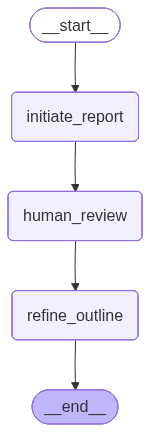

In [35]:
graph

In [36]:
test_state = {'topic':'Long-Context LLM의 시대'}
thread = {'configurable':default, 'thread_id':'0'}

graph.invoke(test_state, config = thread)

# Planner: 

# 보고서 작성 개요:
### 개요
Long-Context LLM의 개념과 중요성, 그리고 보고서에서 다룰 내용에 대한 간략한 소개를 제공합니다.

### Long-Context LLM의 기반 기술
Long-Context LLM을 구현하는 데 사용되는 핵심 기술들을 상세히 분석합니다. 여기에는 Transformer 아키텍처의 발전, Attention 메커니즘, Position Embedding 등이 포함될 수 있습니다.

### Long-Context LLM의 학습 방법
Long-Context LLM을 효과적으로 학습시키기 위한 다양한 방법론을 탐구합니다. 여기에는 데이터 준비, 모델 훈련, Fine-tuning 전략 등이 포함될 수 있습니다.

### Long-Context LLM의 활용 사례
Long-Context LLM이 실제로 어떻게 활용되고 있는지 다양한 사례를 통해 보여줍니다. 여기에는 챗봇, 문서 요약, 정보 검색, 콘텐츠 생성 등이 포함될 수 있습니다.

### Long-Context LLM의 한계점과 해결 과제
Long-Context LLM이 가진 기술적 한계와 윤리적 문제점들을 지적하고, 이를 해결하기 위한 연구 방향을 제시합니다. 여기에는 계산 비용, 정보 손실, 편향 문제 등이 포함될 수 있습니다.

# 추가 질문:
Long-Context LLM 보고서에 대한 추가 질문입니다.
1. 어떤 특정 분야에 Long-Context LLM을 적용하는 것에 관심이 있으신가요? (예: 법률, 의학, 금융 등)
2. 보고서에서 어떤 종류의 Long-Context LLM 모델(예: Transformer 기반, RNN 기반)을 더 자세히 다루기를 원하시나요?
3. Long-Context LLM의 윤리적 문제(예: 편향, 악용 가능성)에 대해 얼마나 자세히 다루기를 원하시나요?
4. 보고서의 형식을 어떻게 구성하면 좋을까요? (예: 기술 보고서, 시장 조사 보고서, 교육 자료 등)
5. Long-Context LLM 관련 특정 회사나 

{'topic': 'Long-Context LLM의 시대',
 'plan': ReportPlan(sections=[Section(name='개요', description='Long-Context LLM의 개념과 중요성, 그리고 보고서에서 다룰 내용에 대한 간략한 소개를 제공합니다.', content=''), Section(name='Long-Context LLM의 기반 기술', description='Long-Context LLM을 구현하는 데 사용되는 핵심 기술들을 상세히 분석합니다. 여기에는 Transformer 아키텍처의 발전, Attention 메커니즘, Position Embedding 등이 포함될 수 있습니다.', content=''), Section(name='Long-Context LLM의 학습 방법', description='Long-Context LLM을 효과적으로 학습시키기 위한 다양한 방법론을 탐구합니다. 여기에는 데이터 준비, 모델 훈련, Fine-tuning 전략 등이 포함될 수 있습니다.', content=''), Section(name='Long-Context LLM의 활용 사례', description='Long-Context LLM이 실제로 어떻게 활용되고 있는지 다양한 사례를 통해 보여줍니다. 여기에는 챗봇, 문서 요약, 정보 검색, 콘텐츠 생성 등이 포함될 수 있습니다.', content=''), Section(name='Long-Context LLM의 한계점과 해결 과제', description='Long-Context LLM이 가진 기술적 한계와 윤리적 문제점들을 지적하고, 이를 해결하기 위한 연구 방향을 제시합니다. 여기에는 계산 비용, 정보 손실, 편향 문제 등이 포함될 수 있습니다.', content='')], followup_question='Long-Context LLM 보고서에 대한 추가 질문입니다.\n1. 어떤 특정 분야에 Long-Context LLM을 적용하는 것에 관심이 있으신가요? (예: 법률, 의학,

In [37]:
for event in graph.stream(
        Command(resume={"human_feedback": """오 나 맘바가 궁금해. Mamba에 대한 얘기만 하는 방향으로 수정해줘."""}),
    thread,
    stream_mode="updates", subgraphs=True
):
    history.append(event)
    for status in event:
        print(f'# {str(status)[:300]}')

        try:
            for key in event[status]:
                value = str(event[status][key])
                if len(value)>300:
                    print(f'- {key}: {value[:300]}')
                else:
                    print(f'- {key}: {value}')
            print('---------')
        except:
            continue

# ()
# {'human_review': {'human_feedback': '오 나 맘바가 궁금해. Mamba에 대한 얘기만 하는 방향으로 수정해줘.'}}
# 수정된 보고서 계획:

    ### 개요
Mamba 모델의 개념과 중요성, 그리고 보고서에서 다룰 내용에 대한 간략한 소개를 제공합니다.

### Mamba의 기반 기술
Mamba 모델을 구현하는 데 사용되는 핵심 기술들을 상세히 분석합니다. 여기에는 State Space 모델, Selective Scan 등이 포함될 수 있습니다.

### Mamba의 학습 방법
Mamba 모델을 효과적으로 학습시키기 위한 다양한 방법론을 탐구합니다. 여기에는 데이터 준비, 모델 훈련, Fine-tuning 전략 등이 포함될 수 있습니다.

### Mamba의 활용 사례
Mamba 모델이 실제로 어떻게 활용되고 있는지 다양한 사례를 통해 보여줍니다. 여기에는 챗봇, 문서 요약, 정보 검색, 콘텐츠 생성 등이 포함될 수 있습니다.

### Mamba의 한계점과 해결 과제
Mamba 모델이 가진 기술적 한계와 윤리적 문제점들을 지적하고, 이를 해결하기 위한 연구 방향을 제시합니다. 여기에는 계산 비용, 정보 손실, 편향 문제 등이 포함될 수 있습니다.

    추가 질문:
    
    
# ()
# {'refine_outline': {'plan': ReportPlan(sections=[Section(name='개요', description='Mamba 모델의 개념과 중요성, 그리고 보고서에서 다룰 내용에 대한 간략한 소개를 제공합니다.', content=''), Section(name='Mamba의 기반 기술', description='Mamba 모델을 구현하는 데 사용되는 핵심 기술들을 상세히 분석합니다. 여기에는 State Space 모델, Selective Scan 등이 포함될 수 있습니다.', content=''), S


In [38]:
def research(state:ResearchState, config: RunnableConfig):
    result = researcher_graph.invoke({
    'topic': state['topic'],
    'section': state['section'],
    'num_revision':0
    })
    draft = result['draft']

    return {'finished_drafts':[draft]}


def start_survey(state:State, config: RunnableConfig):
    topic = state['topic']
    plan = state['plan']
    # Query 생성, 수집, Reflection, 섹션 작성 모듈을 하나의 에이전트로 구성

    return [Send("research",
            {'topic':topic, "section": s}) for s in plan.sections]


def synthesizer(state:State, config: RunnableConfig):
    return {'result':'\n'.join(state['finished_drafts'])}

def finalizer(state:State, config: RunnableConfig):
    prompt = PromptTemplate(template='''
연구 보고서의 내용이 주어집니다.
전체 흐름을 고려하여, 최종 결론 섹션을 작성하세요.

전체 보고서 내용:
{result}''')
    writer_llm = init_chat_model(
        model_provider = config['configurable']['writer_provider'],
        model= config['configurable']['writer_model'],
        rate_limiter=rate_limiter,
        temperature=0.8,
    )
    chain = prompt | writer_llm | StrOutputParser()
    result = chain.invoke({'result':state['result']})
    return {'result':state['result'] + '\n'+result}


In [39]:
builder = StateGraph(State)
builder.add_node(initiate_report)
builder.add_node(human_review)
builder.add_node(refine_outline)
builder.add_node(research)
builder.add_node(synthesizer)
builder.add_node(finalizer)

builder.add_edge(START, 'initiate_report')
builder.add_edge('initiate_report','human_review')
builder.add_edge('human_review', 'refine_outline')

builder.add_conditional_edges("refine_outline", start_survey, ["research"])

builder.add_edge('research', 'synthesizer')
builder.add_edge('synthesizer', 'finalizer')
builder.add_edge('finalizer',END)
memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

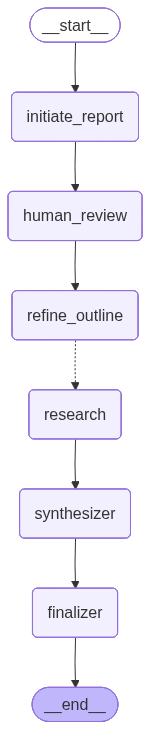

In [40]:
graph

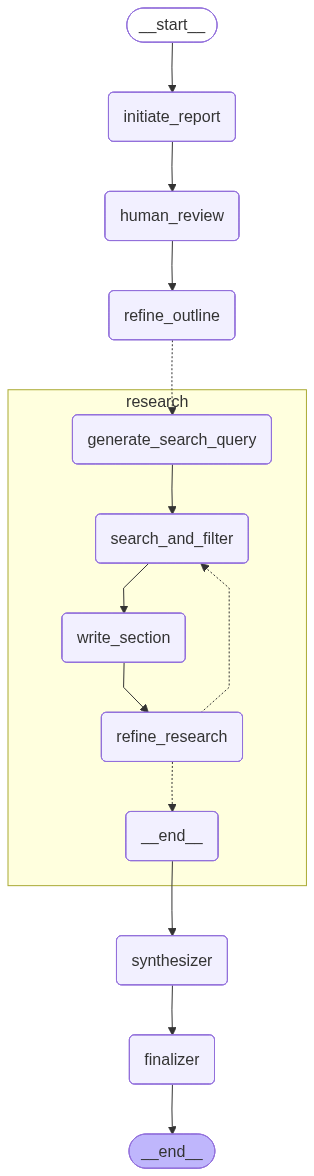

In [41]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

완성된 그래프를 실행해 보겠습니다.

In [42]:
test_state = {'topic':'LLM Agent 개발을 위한 프롬프트 엔지니어링의 중요성'}
thread = {'configurable':default, 'thread_id':'1'}

graph.invoke(test_state, config = thread)

# Planner: 

# 보고서 작성 개요:
### 서론
LLM Agent의 개념과 프롬프트 엔지니어링의 중요성 소개, 보고서의 목표 및 범위 명확화

### LLM Agent의 이해
LLM Agent의 정의, 구성 요소, 작동 방식 상세 설명. 기존 LLM과의 차이점 강조

### 프롬프트 엔지니어링의 기본 원리
프롬프트의 구조, 구성 요소, 설계 기법 등 프롬프트 엔지니어링의 핵심 원리 설명

### LLM Agent 개발을 위한 프롬프트 엔지니어링
LLM Agent의 특정 기능(예: 계획, 추론, 도구 사용)을 구현하기 위한 프롬프트 엔지니어링 전략 및 예시 제시

### 최신 프롬프트 엔지니어링 기법
Chain-of-Thought, ReAct, Self-Consistency 등 LLM Agent의 성능 향상을 위한 최신 프롬프트 엔지니어링 기법 소개 및 비교 분석

### 프롬프트 엔지니어링의 실제 사례
LLM Agent를 활용한 실제 서비스 및 애플리케이션 사례 분석. 성공 및 실패 사례를 통해 시사점 도출

### 프롬프트 엔지니어링의 도전 과제 및 해결 방안
프롬프트 의존성, 일관성 유지, 보안 문제 등 프롬프트 엔지니어링의 한계점 지적 및 극복 방안 제시

### 향후 연구 방향
LLM Agent와 프롬프트 엔지니어링의 발전 가능성 및 미래 전망 제시. 추가 연구 및 개발이 필요한 영역 제시

# 추가 질문:
LLM Agent 개발을 위한 프롬프트 엔지니어링 보고서 초안입니다.
보고서의 방향에 대해 아래 질문에 답변해주시면 감사하겠습니다.
1. 어떤 특정 산업 또는 응용 분야에 LLM Agent를 적용하는 데 관심이 있으신가요? (예: 금융, 의료, 교육, 고객 서비스 등)
2. LLM Agent의 어떤 특정 기능(예: 자연어 이해, 작업 자동화, 의사 결정 지원)에 중점을 두고 싶으신가요?
3. 보고서에서 어떤 종류의 사례 연구 또는 실제 예시를 보고 싶으신가요?
4. 프롬프트 엔지니어링의 특정 측면(예: 효율성, 보안, 윤리적 고려 사항)에

{'topic': 'LLM Agent 개발을 위한 프롬프트 엔지니어링의 중요성',
 'plan': ReportPlan(sections=[Section(name='서론', description='LLM Agent의 개념과 프롬프트 엔지니어링의 중요성 소개, 보고서의 목표 및 범위 명확화', content=''), Section(name='LLM Agent의 이해', description='LLM Agent의 정의, 구성 요소, 작동 방식 상세 설명. 기존 LLM과의 차이점 강조', content=''), Section(name='프롬프트 엔지니어링의 기본 원리', description='프롬프트의 구조, 구성 요소, 설계 기법 등 프롬프트 엔지니어링의 핵심 원리 설명', content=''), Section(name='LLM Agent 개발을 위한 프롬프트 엔지니어링', description='LLM Agent의 특정 기능(예: 계획, 추론, 도구 사용)을 구현하기 위한 프롬프트 엔지니어링 전략 및 예시 제시', content=''), Section(name='최신 프롬프트 엔지니어링 기법', description='Chain-of-Thought, ReAct, Self-Consistency 등 LLM Agent의 성능 향상을 위한 최신 프롬프트 엔지니어링 기법 소개 및 비교 분석', content=''), Section(name='프롬프트 엔지니어링의 실제 사례', description='LLM Agent를 활용한 실제 서비스 및 애플리케이션 사례 분석. 성공 및 실패 사례를 통해 시사점 도출', content=''), Section(name='프롬프트 엔지니어링의 도전 과제 및 해결 방안', description='프롬프트 의존성, 일관성 유지, 보안 문제 등 프롬프트 엔지니어링의 한계점 지적 및 극복 방안 제시', content=''), Section(name='향후 연구 방향', description='LLM Agent와 프롬프트 엔지니어링의 발전 가능성 

In [43]:
# BottleNeck: Search and Filter
# 긴 컨텍스트 모델은 필터링을 안 하는 방법도 고려할 수 있겠습니다..
'''좋아, Gemini 2.5 Pro는
긴 컨텍스트에서도 성능이 엄청 좋던데, 그 부분을 중요하게 다뤄 주고.
Llama 4의 Long Context에 대해서도 알려줘.        '''

history =[]

for event in graph.stream(
        Command(resume={"human_feedback": """좋아,
지금 흐름 좋은데, 특정 프레임워크에 중점을 두기보다는
전반적인 설계에서 프롬프트를 어떻게 써야 하는지에 대한
에이전트에 특화된 노하우가 들어가면 좋겠어."""}),
    thread,
    stream_mode="updates", subgraphs=True
):
    history.append(event)
    for status in event:
        print(f'# {str(status)[:300]}')

        try:
            for key in event[status]:
                value = str(event[status][key])
                if len(value)>300:
                    print(f'- {key}: {value[:300]}')
                else:
                    print(f'- {key}: {value}')
            print('---------')
        except:
            continue

# ()
# {'human_review': {'human_feedback': '좋아,\n지금 흐름 좋은데, 특정 프레임워크에 중점을 두기보다는\n전반적인 설계에서 프롬프트를 어떻게 써야 하는지에 대한\n에이전트에 특화된 노하우가 들어가면 좋겠어.'}}
# 수정된 보고서 계획:

    ### 서론
LLM Agent의 개념과 프롬프트 엔지니어링의 중요성 소개, 보고서의 목표 및 범위 명확화

### LLM Agent의 이해
LLM Agent의 정의, 구성 요소, 작동 방식 상세 설명. 기존 LLM과의 차이점 강조

### 프롬프트 엔지니어링의 기본 원리
프롬프트의 구조, 구성 요소, 설계 기법 등 프롬프트 엔지니어링의 핵심 원리 설명

### LLM Agent 개발을 위한 프롬프트 엔지니어링
LLM Agent의 특정 기능(예: 계획, 추론, 도구 사용)을 구현하기 위한 프롬프트 엔지니어링 전략 및 예시 제시. 에이전트 설계 관점에서 프롬프트 작성 노하우 설명

### 최신 프롬프트 엔지니어링 기법
Chain-of-Thought, ReAct, Self-Consistency 등 LLM Agent의 성능 향상을 위한 최신 프롬프트 엔지니어링 기법 소개 및 비교 분석

### 프롬프트 엔지니어링의 실제 사례
LLM Agent를 활용한 실제 서비스 및 애플리케이션 사례 분석. 성공 및 실패 사례를 통해 시사점 도출

### 프롬프트 엔지니어링의 도전 과제 및 해결 방안
프롬프트 의존성, 일관성 유지, 보안 문제 등 프롬프트 엔지니어링의 한계점 지적 및 극복 방안 제시

### 향후 연구 방향
LLM Agent와 프롬프트 엔지니어링의 발전 가능성 및 미래 전망 제시. 추가 연구 및 개발이 필요한 영역 제시

    추가 질문:
    
    
# ()
# {'refine_outline': {'plan': ReportPlan(sections=[Section(name='서론', description='LLM Agent의 개념과 프롬프트 엔지니어링의 중요성 소개, 보고서의 목

결과물을 md 파일에 저장해 보겠습니다.

In [44]:
result = history[-1][1]['finalizer']['result']
result

'### 서론\n\nLLM Agent는 대규모 언어 모델(LLM)을 기반으로, 계획, 메모리, 도구 활용 등의 핵심 모듈을 결합하여 복잡한 작업을 자율적으로 수행할 수 있는 지능형 시스템입니다 [1]. LLM Agent는 사용자 요청을 이해하고, 필요한 도구를 선택하여 작업을 계획하고 실행하며, 결과를 평가하고 학습하는 과정을 통해 스스로 개선해 나갈 수 있습니다. 이러한 LLM Agent의 핵심 두뇌 역할을 수행하는 LLM은 에이전트의 작동 방식과 사용 가능한 도구에 대한 세부 정보를 담은 프롬프트 템플릿을 통해 활성화됩니다 [1].\n\n프롬프트 엔지니어링은 LLM Agent의 성능을 결정하는 중요한 요소입니다 [1]. 프롬프트는 LLM에게 어떤 작업을 수행해야 하는지, 어떤 방식으로 응답해야 하는지를 지시하는 역할을 합니다. 잘 설계된 프롬프트는 LLM이 원하는 대로 작동하도록 유도하여 LLM Agent의 정확도, 효율성, 안정성을 향상시킬 수 있습니다. 반면, 잘못 설계된 프롬프트는 LLM이 엉뚱한 답변을 생성하거나, 예기치 않은 오류를 발생시키는 원인이 될 수 있습니다.\n\n본 보고서는 LLM Agent 개발에 있어 프롬프트 엔지니어링의 중요성을 강조하고, 효과적인 프롬프트 설계 방법론과 기술을 소개하는 것을 목표로 합니다. 또한, 다양한 LLM Agent 프레임워크와 도구를 살펴보고, 실제 LLM Agent 개발 사례를 분석하여 프롬프트 엔지니어링의 중요성을 입증하고자 합니다. 본 보고서의 범위는 LLM Agent의 기본 개념, 프롬프트 엔지니어링 기술, LLM Agent 프레임워크 및 도구, LLM Agent 개발 사례 분석을 포함합니다.\n\n**References**\n[1] Prompt Engineering Guide. "LLM Agents." *Prompt Engineering Guide*, [https://www.promptingguide.ai/kr/research/llm-agents](https://www.promptingguide.a

In [46]:
with open("example2.md", "w", encoding="utf-8") as f:
    f.write(result)